In [5]:
import sys,os,glob
os.environ['PROJ_LIB'] = '/home/piotr/anaconda3/lib/python3.8/site-packages/rasterio/proj_data/'
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import geopandas
import pandas as pd
from geocube.api.core import make_geocube
from datetime import datetime
from matplotlib.dates import DateFormatter
from PIL import Image
from osgeo import gdal

# Processing MODIS, CHIRPS and observed data to format used by forecasting fuctions
- extracts time series of inundation for each unit
- extracts time series of rainfall for each unit
- converts daily observations to monthly data

### rainfall data

In [6]:
unitsfilepath="../data/gis/delta_units_v7.shp"
rainfallfilepath="../data/rainfall/pr_mon_CHG_CHIRPS-2.0-0p25-prelim_merged_okavango.nc"
floodfilepath="../data/flood/flood_modis_merged.nc"

#these are output files
rainfall4unitsfilepath="../data/rainfall/pr_deltaunits.csv"
rainfallheadwatersfilepath="../data/rainfall/pr_headwaters.csv"
flood4unitsfilepath="../data/flood/flood_deltaunits.csv"
verbose=False

###############################################################################################################
print("reading units file {}".format(unitsfilepath))

if not os.path.exists(unitsfilepath):
    print("Units file {} does not exist. Exiting...".format(unitsfilepath))
    sys.exit()

units = geopandas.read_file(unitsfilepath)
print("done")

print("reading rainfall file {}".format(rainfallfilepath))

if not os.path.exists(rainfallfilepath):
    print("Rainfall file {} does not exist. Exiting...".format(rainfallfilepath))
    sys.exit()
print("done")

#processing rainfall
data=xr.open_dataset(rainfallfilepath,chunks={'time': 20})
pr=data.pr
data.close()
pr=pr.rio.write_crs("epsg:4326")

if verbose:
    fig=plt.figure(figsize=(6,8))
    pl=fig.add_subplot(1,1,1)
    m=(pr.mean("time")*12).sel(latitude=slice(-21,-18), longitude=slice(21,24.5)).plot(add_colorbar=False, cmap=plt.cm.BrBG)
    units.plot(ax=pl, alpha=0.3, edgecolor='black', color="white", linewidth=1)
    plt.colorbar(m, shrink=0.5)
    pl.set_title("mean annual rainfall [mm/year]")
    plt.show()

print("extracting rainfall for units...")
subprpd=pd.DataFrame()
for unit in range(8):
    if verbose:
        print(unit)
    subpr=pr.rio.clip(units.geometry.values[unit:(unit+1)], "epsg:4326")
    subpr=subpr.mean(("latitude","longitude")).to_pandas()
    subpr.name=units["NAME"][unit]
    subprpd=pd.concat([subprpd,subpr], axis=1)
subprpd.index=pd.to_datetime([datetime.date(x) for x in subprpd.index])
print("done")
print("writing rainfall file {}".format(rainfall4unitsfilepath))
np.round(subprpd,2).to_csv(rainfall4unitsfilepath)
print("done")

print("extracting rainfall for upper catchment...")
hwtrpr=pr.sel(latitude=slice(-15,-12.5),longitude=slice(16,20)).mean(("latitude","longitude"))
hwtrpr=pd.DataFrame(hwtrpr.to_pandas(), columns=["pr"])
print("done")

print("writing headwaters rainfall file {}".format(rainfallheadwatersfilepath))
np.round(hwtrpr,2).to_csv(rainfallheadwatersfilepath)
print("done")


reading units file ../data/gis/delta_units_v7.shp
done
reading rainfall file ../data/rainfall/pr_mon_CHG_CHIRPS-2.0-0p25-prelim_merged_okavango.nc
done
extracting rainfall for units...
done
writing rainfall file ../data/rainfall/pr_deltaunits.csv
done
extracting rainfall for upper catchment...
done
writing headwaters rainfall file ../data/rainfall/pr_headwaters.csv
done


### flood data

In [3]:
print("reading flood file {}".format(floodfilepath))

if not os.path.exists(floodfilepath):
    print("Flood file {} does not exist. Run Download notebook. Exiting...".format(floodfilepath))
    sys.exit()

    
    
    
    
data=xr.open_dataset(floodfilepath,chunks={'time': 10})
flood=data.flood
data.close()
flood=flood.rio.write_crs("epsg:4326")
print("done")


print("processing flood")
#inundation map
#clip to units
flood=flood.rio.clip(units.geometry, "epsg:4326")

#this only picks up maps that have few non-classified
nans=(flood==2).sum(("latitude","longitude"))
sel=nans<500
flood=flood[sel.values,:,:]

if verbose:
    fig=plt.figure(figsize=(8,8))
    pl=fig.add_subplot(1,1,1)
    m=flood.sum("time").plot(cmap=plt.cm.Blues, ax=pl,add_colorbar=False)
    units.plot(ax=pl, alpha=0.5, edgecolor='black', color="yellow",linewidth=1)
    plt.colorbar(m, shrink=0.5)
    pl.set_title("Inundation (# of images) \nMODIS")
    plt.show()


subfloodpd=pd.DataFrame()
for unit in range(8):
    if verbose:
        print(unit)
    subflood=flood.rio.clip(units.geometry.values[unit:(unit+1)], "epsg:4326")
    subflood=(subflood.sum(("latitude","longitude"))/4).to_pandas()
    subflood.name=units["NAME"][unit]
    subfloodpd=pd.concat([subfloodpd,subflood], axis=1)
print("done")

print("writing flood file {}".format(flood4unitsfilepath))
subfloodpd.to_csv(flood4unitsfilepath)
print("done")

reading flood file ../data/flood/flood_modis_merged.nc
done
processing flood
done
writing flood file ../data/flood/flood_deltaunits.csv
done


### gauge data



processing toteng
reading ../data/gauge//toteng_dly_combined.csv
done
filtering data
done


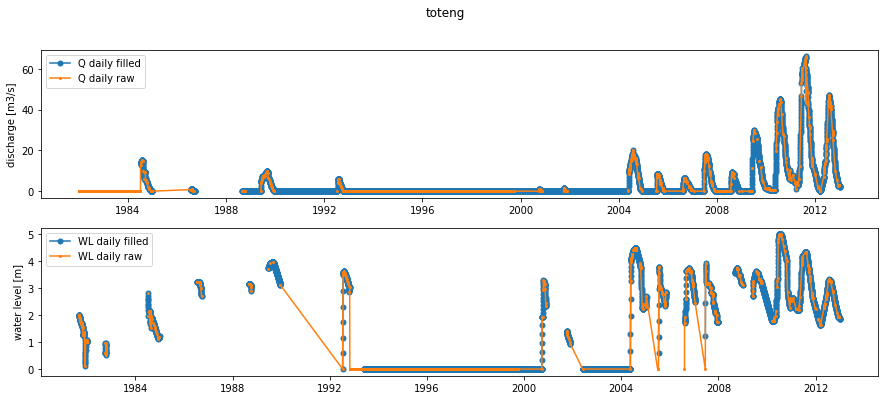

writing filled daily file ../data/gauge//toteng_dly_filled.csv
done
generating monthly data...
done


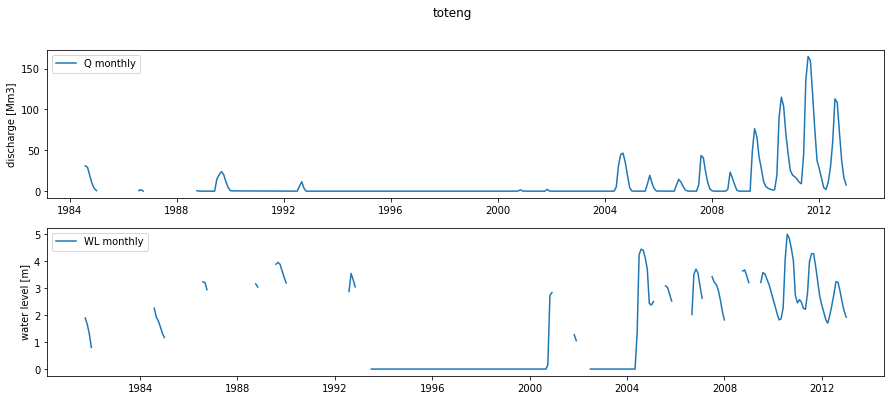

writing monthly file ../data/gauge//toteng_mon.csv
done


processing maun
reading ../data/gauge//maun_dly_combined.csv
done
filtering data
done


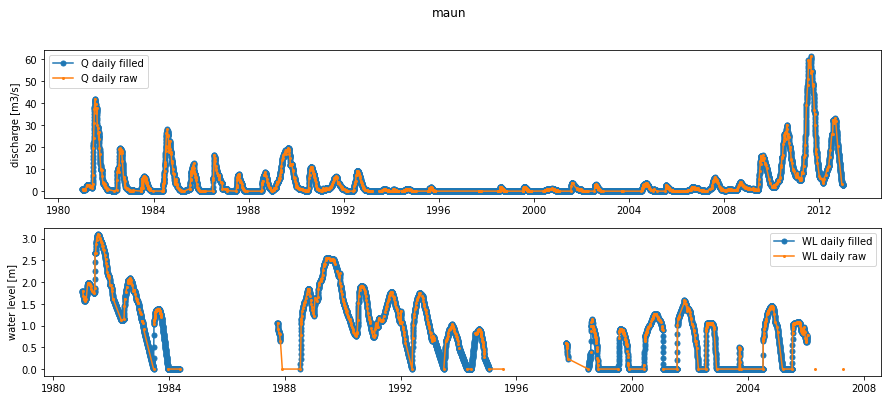

writing filled daily file ../data/gauge//maun_dly_filled.csv
done
generating monthly data...
done


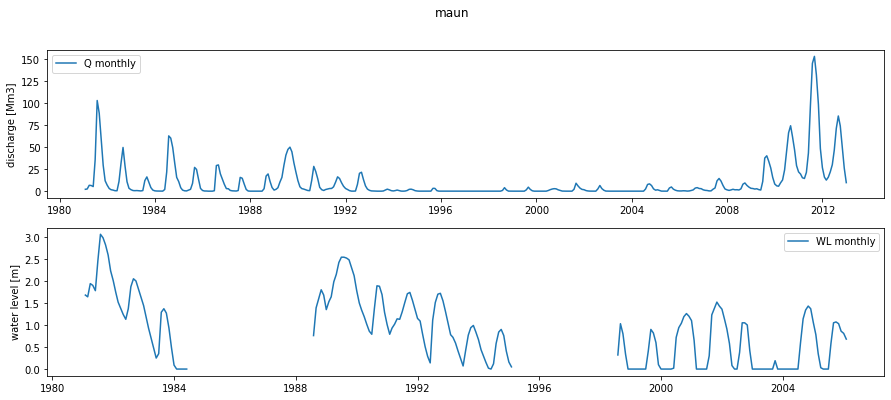

writing monthly file ../data/gauge//maun_mon.csv
done


processing mohembo
reading ../data/gauge//mohembo_dly_combined.csv
done
filtering data
done


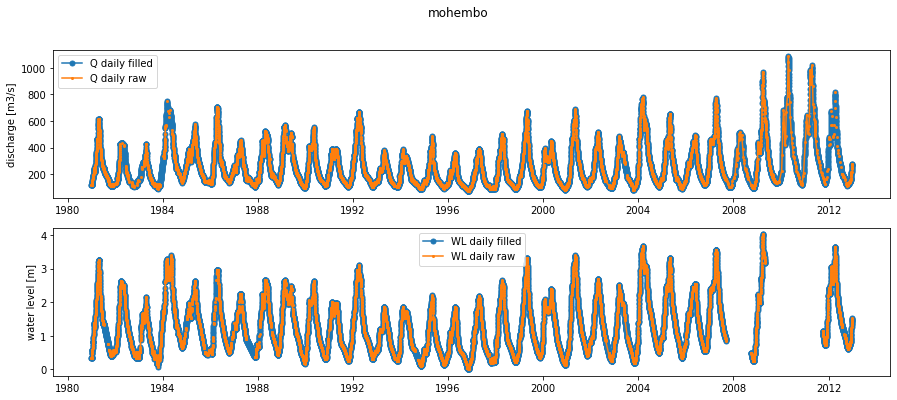

writing filled daily file ../data/gauge//mohembo_dly_filled.csv
done
generating monthly data...
done


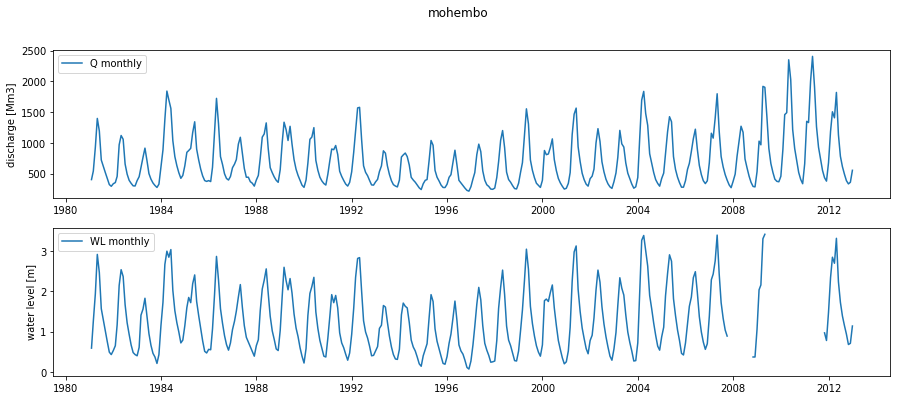

writing monthly file ../data/gauge//mohembo_mon.csv
done


In [8]:
gauges=["toteng","maun","mohembo"]
datadir="../data/gauge/"
fy,ly="1981","2012" #years for which data will be plotted for inspection if verbose=True
verbose=True


########################################################################################################
#be careful editing below this line
for gauge in gauges:
    print("\n\nprocessing {}".format(gauge))
    
    inputfilepath=datadir+"/"+gauge+"_dly_combined.csv"
    filledfilepath=datadir+"/"+gauge+"_dly_filled.csv"
    monthlyfilepath=datadir+"/"+gauge+"_mon.csv"
    print("reading {}".format(inputfilepath))
    data=pd.read_csv(inputfilepath, index_col=0, parse_dates=True)
    print("done")
    #filtering data
    #this is to prepare daily time series for converting to monthly while 
    # distinguishing what we know from what we don't know
    #this basically creates gaps in the time series created by interpolation function 
    #in periods that should not be interpolated across
    # one has to critically evaluate obs data
    print("filtering data")
    datafilled=data.resample("D").mean().interpolate("time",order=3)
    if gauge=="maun":
        datafilled['water level']["1984-05-14":"1987-09-28"][:]=np.nan
        datafilled['water level']["1987-11-07":"1988-07-14"][:]=np.nan
        datafilled['water level']["1995-01-20":"1997-09-18"][:]=np.nan
        datafilled['water level']["1997-10-10":"1998-06-24"][:]=np.nan
        datafilled['water level']["2006-01-21":"2013-11-12"][:]=np.nan
    if gauge=="toteng":    
        datafilled[:]["1971-11-15":"1974-04-25"][:]=np.nan
        datafilled['discharge']["1978-09-29":"1980-10-01"][:]=np.nan
        datafilled['discharge']["1980-11-14":"1984-07-06"][:]=np.nan
        datafilled['water level']["1981-01-01":"1981-09-03"][:]=np.nan
        datafilled['water level']["1982-01-10":"1982-10-01"][:]=np.nan
        datafilled['water level']["1982-10-25":"1984-07-06"][:]=np.nan
        datafilled[:]["1984-12-31":"1986-07-19"][:]=np.nan
        datafilled[:]["1986-09-24":"1988-08-28"][:]=np.nan
        datafilled['water level']["1989-12-23":"1992-07-13"][:]=np.nan
        datafilled['water level']["1988-10-13":"1989-06-22"][:]=np.nan
        datafilled['water level']["1992-10-29":"1993-06-01"][:]=np.nan
        datafilled['water level']["2000-11-29":"2001-10-01"][:]=np.nan
        datafilled['water level']["2001-11-29":"2002-06-01"][:]=np.nan
        datafilled['water level']["2005-01-17":"2005-07-15"][:]=np.nan
        datafilled['water level']["2005-11-10":"2006-08-10"][:]=np.nan
        datafilled['water level']["2007-01-18":"2007-06-19"][:]=np.nan
        datafilled['water level']["2007-12-30":"2008-09-09"][:]=np.nan
        datafilled['water level']["2009-01-01":"2009-06-01"][:]=np.nan
        datafilled[:]["2013-07-23":"2014-05-06"][:]=np.nan
        datafilled['water level']["2014-01-01":"2020-12-31"][:]=np.nan
        datafilled[:]["2018-01-19":"2018-07-14"][:]=np.nan
        datafilled[:]["2018-08-22":"2020-12-31"][:]=np.nan
        datafilled[:]["2014-11-07":"2015-06-11"][:]=np.nan
    if gauge=="mohembo":    
        datafilled['water level']["2007-09-11":"2008-09-30"][:]=np.nan
        datafilled['water level']["2009-05-01":"2011-10-01"][:]=np.nan
    print("done")
    
    if verbose:
        fig=plt.figure(figsize=(15,6))
        pl=fig.add_subplot(2,1,1)
        style="o-"    
        pl.plot(datafilled['discharge'][fy:ly], style, label="Q daily filled", markersize=5)
        pl.plot(data['discharge'][fy:ly], style, label="Q daily raw", markersize=2)

        pl.set_ylabel("discharge [m3/s]")
        plt.legend()

        pl=fig.add_subplot(2,1,2)
        style="o-"
        pl.plot(datafilled['water level'][fy:ly], style, label="WL daily filled", markersize=5)
        pl.plot(data['water level'][fy:ly], style, label="WL daily raw", markersize=2)
        pl.set_ylabel("water level [m]")
        plt.suptitle(gauge)
        plt.legend()
        plt.show()

    print("writing filled daily file {}".format(filledfilepath))
    np.round(datafilled, 2).to_csv(filledfilepath, date_format="%d-%m-%Y")
    print("done")

    print("generating monthly data...")
    datamon=np.round(datafilled.resample("M").mean(),2)
    datamon['discharge']=np.round(np.round(datafilled['discharge'].resample("M").sum(),2)*86400/1000000,2)
    #filtering out nans
    validmon=np.invert(np.isnan(datafilled)).resample("M").sum()
    datamon[validmon<10]=np.nan
    print("done")

    if verbose:
        fig=plt.figure(figsize=(15,6))
        pl=fig.add_subplot(2,1,1)
        pl.plot(datamon['discharge'][fy:ly], "-", label="Q monthly")
        pl.set_ylabel("discharge [Mm3]")
        plt.legend()

        pl=fig.add_subplot(2,1,2)
        pl.plot(datamon['water level'][fy:ly], label="WL monthly")
        pl.set_ylabel("water level [m]")
        plt.legend()
        plt.suptitle(gauge)
        plt.show()

    print("writing monthly file {}".format(monthlyfilepath))
    datamon.to_csv(monthlyfilepath)
    print("done")
